## The Battle of the Neighborhoods -- Coursera Capstone Project 

### Identify the business problem:

    Toronto is the largest city in Canada with an estimated population of more than 6 million, so it is a good place to for entrepreneurs eager to open 
    new businesses that become profitable and get a great number of customers.
    
    The goal of this project is to use the Foursquare API to provide the location data and clustering of venues information to find out what would be the 
    best neighborhoods in the area of Central Toronto to open a new gym venue. Nowadays people are going to gyms more frequently due to the increasing interest
    in a healthy lifestyle.
    
    

### Target audience:

    This project is aimed to entrepreneurs or business owners who want to open a new gym in Central Toronto or grow their current business in a profitable    location where little or no gyms exist today.

### Data:
    
    For the purpose of this project, we will need to have the list of neighborhoods of Toronto city, as well as the geographical location of the Toronto's
    neighborhoods and the venue data for gyms through Foursquare API.
    Here are the details:
        
    * Wikipedia page with the neighborhoods and postal codes of Toronto city (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
    * the geographical coordinates of each postal code through reading the CSV file (https://cocl.us/Geospatial_data)
    * explore and get the venues data using Foursquare API

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd

import json
import requests
from pandas.io.json import json_normalize

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

%matplotlib inline

!pip install lxml html5lib beautifulsoup4

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1i             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  openssl                                 1.1.1h-h516909a_0 --> 1.1.1i-h7f98852_0



openssl-1.1.1i       | 2.1 MB    | #####

### Get the data from the Wikipedia table and transform them into a dataframe

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df = pd.read_html(url, header=0)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# Rename two columns of the dataframes
df.rename(columns={'Postal Code' : 'PostalCode', 'Neighbourhood' : 'Neighborhood'}, inplace=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
# How many boroughs are there?
df['Borough'].value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Name: Borough, dtype: int64

In [5]:
# Drop the cells where the Borough is not assigned
df.drop(df.index[df['Borough'] == 'Not assigned'], inplace=True)

df = df.reset_index(drop=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
# Group the data by PostalCode and Borough
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(','.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
df.shape

(103, 3)

### Read the file with the geographical data of each postal code

In [8]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
geo_df.shape

(103, 3)

In [10]:
# Rename one column in the dataframe
geo_df.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Merge both dataframes on PostalCode
toronto = pd.merge(df, geo_df, on='PostalCode')
toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
# Filter out the data by Boroughs containing "Toronto" in its name to work only with certain Boroughs (downtown Toronto)
toronto_central = toronto[toronto['Borough'].str.contains("Toronto") == 1].reset_index(drop=True)
toronto_central

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


In [13]:
# Create a map of Toronto to plot the Boroughs with "Toronto" in its name
latitude = 43.651070
longitude = -79.347015

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto_central['Latitude'], toronto_central['Longitude'], toronto_central['Borough'], 
                                           toronto_central['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

### Get Foursquare credentials

In [14]:
CLIENT_ID = 'UKO1NLU4ORXTTMYL105W4DNWI0B1UP2LIJTOVDZSSGGFUGKC'
CLIENT_SECRET = 'HMQYZHA10O3PPL1WVKDNGZ21K5BHFHKHPVQSFUBQY4PSRS1U'
VERSION = '20201001'
LIMIT = 100

In [15]:
# Select the first Neighborhood of downtown Toronto dataframe
toronto_central.loc[0, 'Neighborhood']

'The Beaches'

In [16]:
# Get the latitude and longitude of the 1st Neighborhood
neighborhood_latitude = toronto_central.loc[0, 'Latitude']
neighborhood_longitude = toronto_central.loc[0, 'Longitude']

neighborhood_name = toronto_central.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, neighborhood_latitude, neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


In [17]:
# Create the GET request url
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighborhood_latitude,
    neighborhood_longitude,
    radius,
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=UKO1NLU4ORXTTMYL105W4DNWI0B1UP2LIJTOVDZSSGGFUGKC&client_secret=HMQYZHA10O3PPL1WVKDNGZ21K5BHFHKHPVQSFUBQY4PSRS1U&v=20201001&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [18]:
# Send the GET request and the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fd75047bac1690066406505'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682094413784,
          'lng': -79.29394208780985}],
        'distanc

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
# clean the json and structure it into a dataframe
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


#### Explore the data in Central Toronto

In [22]:
# Function to repeat the process to all the Neighborhoods in downtown Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
    
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_central_venues = getNearbyVenues(names=toronto_central['Neighborhood'],
                                latitudes=toronto_central['Latitude'],
                                longitudes=toronto_central['Longitude'])

toronto_central_venues.shape

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

(1624, 7)

In [24]:
print(toronto_central_venues.shape)
print('There are {} uniques categories.'.format(len(toronto_central_venues['Venue Category'].unique())))
toronto_central_venues

(1624, 7)
There are 235 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
...,...,...,...,...,...,...,...
1619,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1620,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1621,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher
1622,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


In [25]:
# How many venues per Neighborhood?
toronto_central_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


#### Are there gyms in the venues?

In [26]:
"Gym" in toronto_central_venues['Venue Category'].unique()

# true/false

True

#### Analyze each Neighborhood

In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_central_venues[['Venue Category']], prefix="", prefix_sep="")

# add Borough column to the dataframe
toronto_onehot['Neighborhoods'] = toronto_central_venues['Neighborhood']

# move Neighborhood to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1624, 236)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Let's group data by Neighborhood and by the mean of the frequency of ocurrence of each category

toronto_grouped = toronto_onehot.groupby(['Neighborhoods']).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(39, 236)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,Central Bay Street,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.014706,0.0,0.0,0.014706,0.014706


In [29]:
#### Print each neighborhood with the top 5 common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhoods']:
    print('....'+hood+'.....')
    top = toronto_grouped[toronto_grouped['Neighborhoods'] == hood].T.reset_index()
    top.columns = ['venue', 'freq']
    top = top.iloc[1:]
    top['freq'] = top['freq'].astype(float)
    top = top.round({'freq': 2})
    print(top.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

....Berczy Park.....
            venue  freq
0     Coffee Shop  0.09
1     Cheese Shop  0.04
2      Restaurant  0.04
3          Bakery  0.04
4  Farmers Market  0.04


....Brockton, Parkdale Village, Exhibition Place.....
            venue  freq
0            Café  0.13
1       Nightclub  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4             Gym  0.04


....Business reply mail Processing Centre, South Central Letter Processing Plant Toronto.....
           venue  freq
0           Park  0.06
1  Auto Workshop  0.06
2        Brewery  0.06
3     Skate Park  0.06
4  Burrito Place  0.06


....CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport.....
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2             Plane  0.06
3   Harbor / Marina  0.06
4  Sculpture Garden  0.06


....Central Bay Street.....
                venue  freq
0         Coffee Shop  0.18
1                Café  0.06
2      Sandwi

In [30]:
gym_data = toronto_grouped[['Neighborhoods', 'Gym']]
gym_data.head()


,Neighborhoods,Gym
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.043478
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.000000


### Cluster the neighborhoods using KMeans clustering

In [31]:
X = gym_data.drop(['Neighborhoods'], axis=1)

#### To find out the optimal number of clusters, we will uses the Elbow Method; training multiple models using different number of clusters and storing the value of inertia_ property (wcss) every time

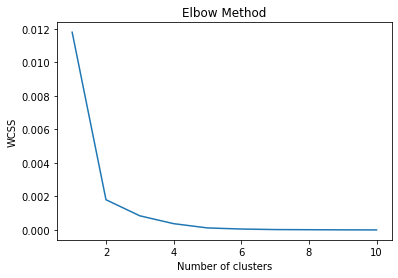

In [32]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### We can conclude that the optimum K value is 5, so we will have 5 clusters.

In [33]:
### Run k-means clustering
kclusters = 5

toronto_grouped_clustering = gym_data.drop('Neighborhoods', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([0, 4, 0, 0, 0, 0, 3, 4, 1, 0], dtype=int32)

In [34]:
### Create a new dataframe that includes the clusters
toronto_merged = gym_data.copy()

toronto_merged['Cluster Labels'] = kmeans.labels_

In [35]:
toronto_merged.head()

,Neighborhoods,Gym,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.043478,4
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.000000,0


In [36]:
### Merge toronto_merged with toronto_venues
toronto_merged = toronto_merged.join(toronto_central_venues.set_index('Neighborhood'), on='Neighborhoods')

print(toronto_merged.shape)
toronto_merged.head()

(1624, 9)


,Neighborhoods,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.0,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar
0,Berczy Park,0.0,0,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [37]:
### Sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(['Cluster Labels'], inplace=True)
toronto_merged

(1624, 9)


,Neighborhoods,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.00,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,BYOB Cocktail Emporium,43.644447,-79.417757,Miscellaneous Shop
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,Le Dolci,43.650377,-79.415959,Cupcake Shop
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,Pilot Coffee Roasters,43.646610,-79.419606,Coffee Shop
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,Trinity Bellwoods Park,43.647072,-79.413756,Park
...,...,...,...,...,...,...,...,...,...
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,Bosk at Shangri-La,43.649023,-79.385826,Asian Restaurant


In [38]:
toronto_merged.rename(columns={'Neighborhoods' : 'Neighborhood'}, inplace=True)
toronto_merged

,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.00,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,BYOB Cocktail Emporium,43.644447,-79.417757,Miscellaneous Shop
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,Le Dolci,43.650377,-79.415959,Cupcake Shop
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,Pilot Coffee Roasters,43.646610,-79.419606,Coffee Shop
19,"Little Portugal, Trinity",0.00,0,43.647927,-79.419750,Trinity Bellwoods Park,43.647072,-79.413756,Park
...,...,...,...,...,...,...,...,...,...
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel
25,"Richmond, Adelaide, King",0.04,4,43.650571,-79.384568,Bosk at Shangri-La,43.649023,-79.385826,Asian Restaurant


In [39]:
### Check how many gyms are there?
toronto_merged['Venue Category'].value_counts()['Gym']

26

### We know that there are 26 locations of gym in Toronto Central
### Let's create a map with the clusters and Neighborhoods

In [40]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], 
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### How many Neighborhoods per cluster?

In [41]:
gym_data['Cluster Labels'] = kmeans.labels_
gym_data.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhoods,Gym,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.043478,4
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.000000,0


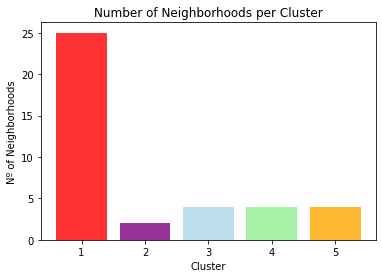

In [42]:
objects = (1, 2, 3, 4, 5)
y_pos = np.arange(len(objects))
performance = gym_data['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple', 'lightblue', 'lightgreen', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('Nº of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

plt.show()

In [43]:
gym_data['Cluster Labels'].value_counts()

0    25
4     4
3     4
2     4
1     2
Name: Cluster Labels, dtype: int64

### Examine the clusters

In [44]:
#### let's create a new dataframe with Neighborhood and Borough
toronto_new = toronto[['Borough', 'Neighborhood']]
toronto_new.head()

,Borough,Neighborhood
0,Scarborough,"Malvern, Rouge"
1,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,Scarborough,"Guildwood, Morningside, West Hill"
3,Scarborough,Woburn
4,Scarborough,Cedarbrae


In [45]:
#### Cluster 1
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
cluster1_df = pd.merge(toronto_new, cluster1, on='Neighborhood')
cluster1_df

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
2,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
3,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
4,East Toronto,"The Danforth West, Riverdale",0.0,0,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
...,...,...,...,...,...,...,...,...,...,...
622,East Toronto,"Business reply mail Processing Centre, South C...",0.0,0,43.662744,-79.321558,The Sidekick,43.664484,-79.325162,Comic Shop
623,East Toronto,"Business reply mail Processing Centre, South C...",0.0,0,43.662744,-79.321558,Leslieville Farmers Market,43.664901,-79.319784,Farmers Market
624,East Toronto,"Business reply mail Processing Centre, South C...",0.0,0,43.662744,-79.321558,Rorschach Brewing Co.,43.663483,-79.319824,Brewery
625,East Toronto,"Business reply mail Processing Centre, South C...",0.0,0,43.662744,-79.321558,Revolution Recording,43.662561,-79.326940,Recording Studio


In [46]:
cluster1_df.sort_values(['Gym'], ascending=False)

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
421,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.0,0,43.653206,-79.400049,Global Cheese,43.654623,-79.400606,Cheese Shop
414,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.0,0,43.653206,-79.400049,Little Pebbles,43.654883,-79.400264,Coffee Shop
415,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.0,0,43.653206,-79.400049,El Rey,43.652764,-79.400048,Cocktail Bar
416,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.0,0,43.653206,-79.400049,Millie Creperie,43.654994,-79.399829,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...
209,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
210,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
211,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
212,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Soulpepper Theatre,43.650780,-79.357615,Theater


In [47]:
cluster1_df['Venue Category'].value_counts(ascending=False)['Gym']

KeyError: 'Gym'

In [48]:
#### Cluster2
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
cluster2_df = pd.merge(toronto_new, cluster2, on='Neighborhood')
cluster2_df

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Subway,43.666052,-79.316933,Sandwich Place
1,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Pizzaiolo,43.668953,-79.311683,Pizza Place
2,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Country Style,43.667662,-79.312006,Coffee Shop
3,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Measurement Park,43.666916,-79.312631,Park
4,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Alliance Cinemas - The Beach,43.666747,-79.314685,Movie Theater
5,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Harvey's,43.666528,-79.315127,Restaurant
6,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,The Tulip Steakhouse,43.666348,-79.316854,Steakhouse
7,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Burrito Bandidos,43.666445,-79.316447,Burrito Place
8,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Murphy's Law,43.667319,-79.312656,Pub
9,East Toronto,"India Bazaar, The Beaches West",0.052632,1,43.668999,-79.315572,Pet Valu,43.666979,-79.314665,Pet Store


In [49]:
cluster2_df.sort_values(['Gym'], ascending=False)

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
26,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Marcheleo's Gourmet Marketplace,43.708041,-79.392195,Gourmet Shop
39,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Viva Napoli,43.705752,-79.389125,Pizza Place
29,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Thobors Boulangerie Patisserie Café,43.704514,-79.388616,Café
30,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Marigold Indian Bistro,43.702881,-79.388008,Indian Restaurant
31,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Zee Grill,43.704985,-79.388476,Seafood Restaurant
32,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Starbucks,43.705923,-79.389548,Coffee Shop
33,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,June Rowlands Park,43.700517,-79.389189,Park
34,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Sakae Sushi,43.704944,-79.388704,Sushi Restaurant
35,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Florentia Ristorante,43.703594,-79.387985,Italian Restaurant
36,Central Toronto,Davisville,0.060606,1,43.704324,-79.388790,Positano,43.704558,-79.388639,Italian Restaurant


In [50]:
cluster2_df['Venue Category'].value_counts(ascending=False)['Gym']

3

In [51]:
#### Cluster3
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
cluster3_df = pd.merge(toronto_new, cluster3, on='Neighborhood')
cluster3_df

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,St. James Town,0.023529,2,43.651494,-79.375418,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar
1,Downtown Toronto,St. James Town,0.023529,2,43.651494,-79.375418,Loaded Pierogi,43.647965,-79.373427,Comfort Food Restaurant
2,Downtown Toronto,St. James Town,0.023529,2,43.651494,-79.375418,Biff's Bistro,43.647085,-79.376342,French Restaurant
3,Downtown Toronto,St. James Town,0.023529,2,43.651494,-79.375418,The Gabardine,43.650988,-79.381225,American Restaurant
4,Downtown Toronto,St. James Town,0.023529,2,43.651494,-79.375418,John Allans,43.651447,-79.381354,Salon / Barbershop
...,...,...,...,...,...,...,...,...,...,...
242,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,2,43.662301,-79.389494,Starbucks,43.658204,-79.388998,Coffee Shop
243,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,2,43.662301,-79.389494,Booster Juice,43.658657,-79.388682,Smoothie Shop
244,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,2,43.662301,-79.389494,Starbucks,43.659456,-79.390411,Coffee Shop
245,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,2,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant


In [52]:
cluster3_df.sort_values(['Gym'], ascending=False)

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
246,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,2,43.662301,-79.389494,Queen's Park,43.663946,-79.392180,Park
196,West Toronto,"Runnymede, Swansea",0.030303,2,43.651571,-79.484450,Awai,43.650412,-79.478477,Vegetarian / Vegan Restaurant
211,West Toronto,"Runnymede, Swansea",0.030303,2,43.651571,-79.484450,The Coffee Bouquets,43.648785,-79.485940,Coffee Shop
210,West Toronto,"Runnymede, Swansea",0.030303,2,43.651571,-79.484450,(The New) Moksha Yoga Bloor West,43.648658,-79.485242,Yoga Studio
208,West Toronto,"Runnymede, Swansea",0.030303,2,43.651571,-79.484450,Supper Solved,43.648781,-79.485233,Restaurant
...,...,...,...,...,...,...,...,...,...,...
139,Downtown Toronto,Stn A PO Boxes,0.020833,2,43.646435,-79.374846,NAMI,43.650853,-79.375887,Japanese Restaurant
140,Downtown Toronto,Stn A PO Boxes,0.020833,2,43.646435,-79.374846,The Old Spaghetti Factory,43.646964,-79.374403,Italian Restaurant
141,Downtown Toronto,Stn A PO Boxes,0.020833,2,43.646435,-79.374846,Anton Kozlik's mustard,43.648752,-79.371485,Gourmet Shop
142,Downtown Toronto,Stn A PO Boxes,0.020833,2,43.646435,-79.374846,Petit Four Bakery,43.647744,-79.379588,Sandwich Place


In [53]:
cluster3_df['Venue Category'].value_counts(ascending=False)['Gym']

6

In [54]:
#### Cluster4
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]
cluster4_df = pd.merge(toronto_new, cluster4, on='Neighborhood')
cluster4_df

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Rolltation,43.669388,-79.386566,Sushi Restaurant
1,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Storm Crow Manor,43.666840,-79.381593,Theme Restaurant
2,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,DanceLifeX Centre,43.666956,-79.385297,Dance Studio
3,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,The Alley,43.665922,-79.385567,Bubble Tea Shop
4,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Fabarnak,43.666377,-79.380964,Restaurant
...,...,...,...,...,...,...,...,...,...,...
370,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",0.010000,3,43.647177,-79.381576,Chotto Matte,43.646473,-79.378782,Japanese Restaurant
371,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",0.010000,3,43.647177,-79.381576,Earls Kitchen & Bar,43.647946,-79.383706,Bar
372,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",0.010000,3,43.647177,-79.381576,Café Plenty,43.649118,-79.378313,Café
373,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",0.010000,3,43.647177,-79.381576,Pizzeria Libretto,43.648334,-79.385111,Pizza Place


In [55]:
cluster4_df.sort_values(['Gym'], ascending=False)

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Rolltation,43.669388,-79.386566,Sushi Restaurant
48,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,The Blake House,43.664468,-79.377471,American Restaurant
55,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Boutique Bar,43.664219,-79.380412,Gay Bar
54,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Cawthra Square Dog Park,43.666583,-79.380040,Dog Run
53,Downtown Toronto,Church and Wellesley,0.013333,3,43.665860,-79.383160,Woody's and Sailor,43.664390,-79.380361,Gay Bar
...,...,...,...,...,...,...,...,...,...,...
173,Downtown Toronto,"Garden District, Ryerson",0.010000,3,43.657162,-79.378937,The Black Canary Espresso Bar,43.657029,-79.381385,Café
172,Downtown Toronto,"Garden District, Ryerson",0.010000,3,43.657162,-79.378937,Ed Mirvish Theatre,43.655102,-79.379768,Theater
171,Downtown Toronto,"Garden District, Ryerson",0.010000,3,43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place
170,Downtown Toronto,"Garden District, Ryerson",0.010000,3,43.657162,-79.378937,Jazz Bistro,43.655678,-79.379276,Music Venue


In [56]:
cluster4_df['Venue Category'].value_counts(ascending=False)['Gym']

4

In [57]:
#### Cluster5
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]
cluster5_df = pd.merge(toronto_new, cluster5, on='Neighborhood')
cluster5_df

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Richmond, Adelaide, King",0.040000,4,43.650571,-79.384568,Soup Nutsy,43.647858,-79.380533,Soup Place
1,Downtown Toronto,"Richmond, Adelaide, King",0.040000,4,43.650571,-79.384568,Starbucks,43.646891,-79.381871,Coffee Shop
2,Downtown Toronto,"Richmond, Adelaide, King",0.040000,4,43.650571,-79.384568,Pi Co.,43.648651,-79.385874,Pizza Place
3,Downtown Toronto,"Richmond, Adelaide, King",0.040000,4,43.650571,-79.384568,Boxcar Social Temperance,43.650557,-79.381956,Bar
4,Downtown Toronto,"Richmond, Adelaide, King",0.040000,4,43.650571,-79.384568,Burrito Boyz,43.648446,-79.387995,Burrito Place
...,...,...,...,...,...,...,...,...,...,...
318,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Uma Cafe,43.637016,-79.424048,Café
319,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Queen Supermarket,43.634265,-79.429112,Grocery Store
320,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Cinema Nightclub,43.637614,-79.423890,Nightclub
321,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Brodflour,43.637535,-79.422761,Bakery


In [58]:
cluster5_df.sort_values(['Gym'], ascending=False)

,Borough,Neighborhood,Gym,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
322,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Lamport Stadium,43.638778,-79.423534,Stadium
311,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Gardiner Expy & Dufferin St,43.633800,-79.425460,Intersection
300,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Dunn Milk Variety,43.633667,-79.431549,Convenience Store
301,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,Joe Rockhead's Climbing Gym,43.636342,-79.423582,Climbing Gym
302,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.043478,4,43.636847,-79.428191,RED Nightclub,43.637794,-79.423759,Nightclub
...,...,...,...,...,...,...,...,...,...,...
106,Downtown Toronto,"Commerce Court, Victoria Hotel",0.040000,4,43.648198,-79.379817,iQ Food Co,43.647482,-79.379104,Fast Food Restaurant
105,Downtown Toronto,"Commerce Court, Victoria Hotel",0.040000,4,43.648198,-79.379817,Prairie Girl Bakery,43.648332,-79.382305,Cupcake Shop
104,Downtown Toronto,"Commerce Court, Victoria Hotel",0.040000,4,43.648198,-79.379817,McEwan Foods,43.647160,-79.381044,Deli / Bodega
103,Downtown Toronto,"Commerce Court, Victoria Hotel",0.040000,4,43.648198,-79.379817,Metropolitan Resto Bar,43.650062,-79.377181,Italian Restaurant


In [59]:
cluster5_df['Venue Category'].value_counts(ascending=False)['Gym']

13

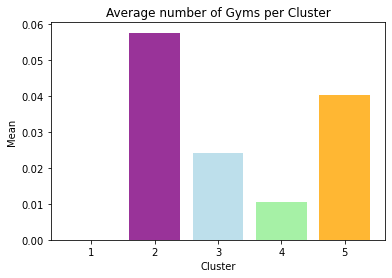

In [61]:
#### Plot the average number of gyms per Cluster

clusters_mean = [cluster1_df['Gym'].mean(), cluster2_df['Gym'].mean(), cluster3_df['Gym'].mean(), cluster4_df['Gym'].mean(), cluster5_df['Gym'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple', 'lightblue', 'lightgreen', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Gyms per Cluster')

plt.show()

#### Final observations:
With this analysis we can note that most of the Gyms are located in clusters 2 (0.06 avg.) and 5 (0.04 avg.) while cluster 1 has the highest number of neighborhoods with no gym. Also, from the map, we can observe that the neighborhoods of Cluster 1 are evenly spread in downtown Toronto area.

#### Conclusion:

Most of the gyms places are located in the neighborhoods of cluster 2 represented by purple color, namely the neighborhood located in Central Toronto that have the highest average of gyms is Davisville and India Bazaar and The Beaches West in East Toronto. The second cluster in number of gyms is the cluster 5 where Brockton, Parkdale Village and Exhibition Place neighborhoods have an average of 0.04 gyms.
So the optimum place to open a new gym is in the neighborhoods grouped in cluster 1, that is The Beaches in East Toronto and Kensington Market, Chinatown and Grange Park in Downtown Toronto. So having 25 neighborhoods in the area with no gym venue is a great opportunity for opening a new one.
